In [31]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [32]:
df = pd.read_csv('../datasets/Interbank FX Rates Historical (full).csv')
df.head()

,Date,USDGHS,GBPGHS
0,31 Dec 2020,7.8787,5.7631
1,30 Dec 2020,7.8087,5.7371
2,29 Dec 2020,7.7383,5.7351
3,24 Dec 2020,7.7779,5.7351
4,23 Dec 2020,7.7344,5.7241


In [33]:
df['USDGHS'] = pd.to_numeric(df['USDGHS'], errors='coerce')
df['GBPGHS'] = pd.to_numeric(df['GBPGHS'], errors='coerce')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
# Resample the DataFrame to a daily frequency and forward-fill missing values
df = df.resample('D').ffill()
df = df.fillna(method='bfill')
df.describe()

,USDGHS,GBPGHS
count,4748.000000,4748.000000
mean,4.320325,3.040635
std,1.846412,1.547481
min,0.000000,0.000000
25%,2.454700,1.522400
50%,4.878600,3.011850
75%,5.922800,4.404125
max,7.878700,5.763100


In [34]:
GBPGHS = df['GBPGHS']

It is not necessary to check for autocorrelation in time series before using LSTM. However, it is important to check for autocorrelation in time series data before using any time series model. Autocorrelation is a measure of the correlation between the values of a time series at different points in time. If there is autocorrelation in the data, it means that the values of the time series at one point in time are correlated with the values at other points in time. This can lead to biased estimates of the model parameters and can affect the accuracy of the model predictions

In [35]:
def Model_data_setup(data, lookback, delay, min_index, max_index):
    """
    data:     Shape (n_samples, n_features). First column is the time series, other columns are the features.
              If there is only one column, it is assumed to be the time series data.
    lookback: Number of time steps in the Model >= 1
    delay:    The number of time steps to predict >= 1.
    min_index,max_index: The starting and ending indices of the time series portion to construct the data.
                         Allows constructing validation and test sets from the series in proper shape
    Returns: A tuple (x, y) of numpy arrays where x is in shape (n_samples, n_timesteps, n_features) and 
             y is in shape (n_samples, delay). y is an array of target arrays each of size delay. To forecast 
             a single value n timesteps ahead, set delay = n and take the last element of the forecast array.
    """
    if data.ndim == 1:
        data = np.expand_dims(data, axis=1)
    n_samples = max_index - lookback - delay + 1
    x_shape = (n_samples, lookback, data.shape[1])
    x = np.zeros(x_shape)
    y_shape = (n_samples, delay)
    y = np.zeros(y_shape)

    for i in range(n_samples):
        start_index = i + min_index
        end_index = start_index + lookback
        x[i,:,:] = data[start_index:end_index,:]
        y[i,:] = data[end_index + delay - 1, 0]

    return x, y


In [36]:
xdata, ydata = Model_data_setup(GBPGHS.values, lookback=5, delay=1, min_index=0, max_index=len(GBPGHS)-1)

### Splitting the dataset into the training and testing sets

We are splitting the dataset of normalized stock Rates into 80$\%$ and 20$\%$ for training and testing respectively. 20 $\%$ of training set will be assigned for validation at later stage.

In [37]:
#Specifying the sizes of training and testing datasets.
train_size = int(len(xdata)*0.6) # 2416#
valid_size = int(len(xdata)*0.2) #605#
test_size = len(xdata) - train_size-valid_size #355#

#Splitting the dataset into trainig, validation and testing.
xtrain, xvalid, xtest = xdata[0:train_size,:], xdata[train_size:train_size+valid_size,:], xdata[train_size+valid_size:len(xdata),:]
ytrain, yvalid, ytest = ydata[0:train_size,:], ydata[train_size:train_size+valid_size,:], ydata[train_size+valid_size:len(ydata),:]

print('The shape of the training sample is: ', xtrain.shape)
print('The shape of the validation sample is: ', xvalid.shape)
print('The shape of the testing sample is: ', xtest.shape)
print('The shape of the training target is: ', ytrain.shape)
print('The shape of the validation target is: ', yvalid.shape)
print('The shape of the testing target is: ', ytest.shape)

The shape of the training sample is:  (2845, 5, 1)
The shape of the validation sample is:  (948, 5, 1)
The shape of the testing sample is:  (949, 5, 1)
The shape of the training target is:  (2845, 1)
The shape of the validation target is:  (948, 1)
The shape of the testing target is:  (949, 1)


In [38]:
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], -1))
xvalid = np.reshape(xvalid, (xvalid.shape[0], xvalid.shape[1], -1))
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], -1))
xtrain.shape,xvalid.shape,xtest.shape

((2845, 5, 1), (948, 5, 1), (949, 5, 1))

## Neural Networks Models

In [39]:
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM,GRU,Conv1D, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [40]:
n_features = USDGHS.shape
lr = 0.0016#Learning rate
units = 16 #Number hidden units
batch_size=64
lookback = 5
delay = 1
min_index = 0
max_index = USDGHS.shape[0] - 1

# Define the number of features in the input data
n_features = 1  # We only have one feature, which is the USDGHS exchange rate

# # Convert the data into the required format for the model
# xdata, ydata = Model_data_setup(GBPGHS.values.reshape(-1, 1), lookback, delay, min_index, max_index)


In [43]:
# Define RNN model
RNN = Sequential()
RNN.add(SimpleRNN(units, activation='relu', input_shape=(lookback, n_features), return_sequences=False, recurrent_dropout=0.3))
RNN.add(Dense(5))
RNN.add(Reshape((5, 1)))

RNN.compile(optimizer='Adam', loss='mse', metrics=['mae'])
RNN.summary()
np.random.seed(123)
history_1=RNN.fit(xtrain,ytrain, validation_data=(xvalid,yvalid),
                   epochs=100,
                   verbose=1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 16)                288       
                                                                 
 dense_1 (Dense)             (None, 5)                 85        
                                                                 
 reshape_1 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 373
Trainable params: 373
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
89/89 [==============================] - 7s 22ms/step - loss: 3.4392 - mae: 1.6545 - val_loss: 7.9305 - val_mae: 2.7649
Epoch 2/100
89/89 [==============================] - 1s 13ms/step - loss: 0.9773 - mae: 0.7593 - val_loss: 1.4621 - val_mae: 1.1683
Epoch 3/100
89/89 [==============================] - 1s 

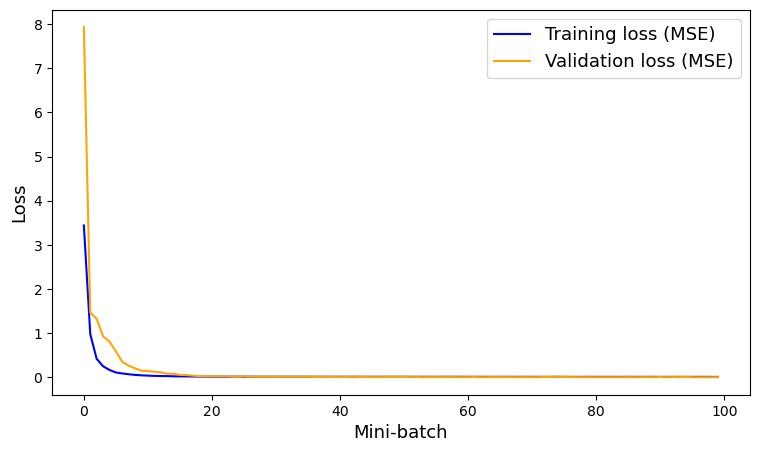

In [44]:
RNN_df = pd.DataFrame(history_1.history)
print('')
plt.figure(figsize=(9,5))
plt.plot(RNN_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(RNN_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
# plt.savefig('../images/RNN_error1.png', format='png', dpi=1000)
plt.show()

In [45]:
LSTM_Model = tf.keras.models.Sequential([
    Input(shape=(lookback, n_features)),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(5)
    # Reshape((5, 1))
])

LSTM_Model.compile(loss='mse', optimizer='Adam' , metrics=["mae"])
LSTM_Model.summary()

np.random.seed(123)
history_2=LSTM_Model.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=50, verbose=1)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                                 
Total params: 12,837
Trainable params: 12,837
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
89/89 [==============================] - 14s 38ms/step - loss: 1.9646 - mae: 1.1376 - val_loss: 1.4350 - val_mae: 1.1288
Epoch 2/50
89/89 [==============================] - 2s 21ms/step - loss: 0.0429 - mae: 0.1327 - val_loss: 0.1375 - val_mae: 0.3285
Epoch 3/50
89/89 [==============================] -

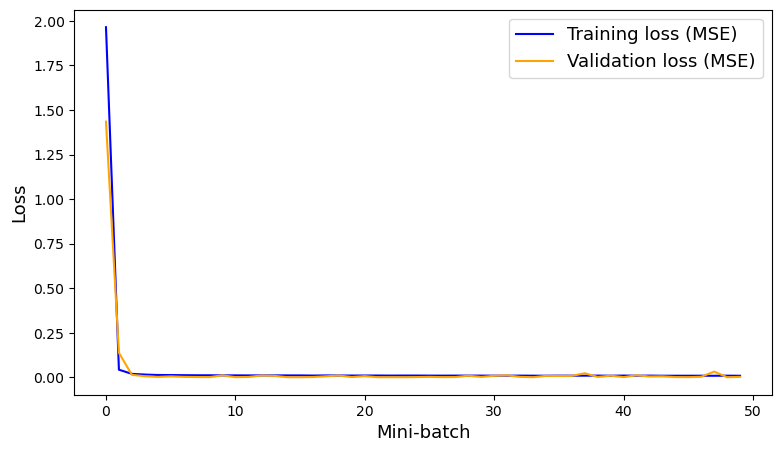

In [59]:
LSTM_df = pd.DataFrame(history_2.history)
print('')
plt.figure(figsize=(9,5))
plt.plot(LSTM_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(LSTM_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
# plt.savefig('../images/LSTM_error1.png', format='png', dpi=1000)
plt.show()

In [46]:
# Define GRU model
GRU_Model = tf.keras.models.Sequential([
    Input(shape=(lookback, n_features)),
    GRU(128, return_sequences=True),
    Dense(5),
    Dense(1)
])

GRU_Model.compile(optimizer = 'Adam', loss='mse', metrics=["mae"])
GRU_Model.summary()
np.random.seed(123)
history_3=GRU_Model.fit(xtrain,ytrain, validation_data=(xvalid,yvalid), epochs=50, verbose=1)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 128)            50304     
                                                                 
 dense_3 (Dense)             (None, 5, 5)              645       
                                                                 
 dense_4 (Dense)             (None, 5, 1)              6         
                                                                 
Total params: 50,955
Trainable params: 50,955
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
89/89 [==============================] - 16s 49ms/step - loss: 0.5824 - mae: 0.4921 - val_loss: 0.4484 - val_mae: 0.4975
Epoch 2/50
89/89 [==============================] - 2s 26ms/step - loss: 0.0493 - mae: 0.1260 - val_loss: 0.0463 - val_mae: 0.1212
Epoch 3/50
89/89 [==============================] -

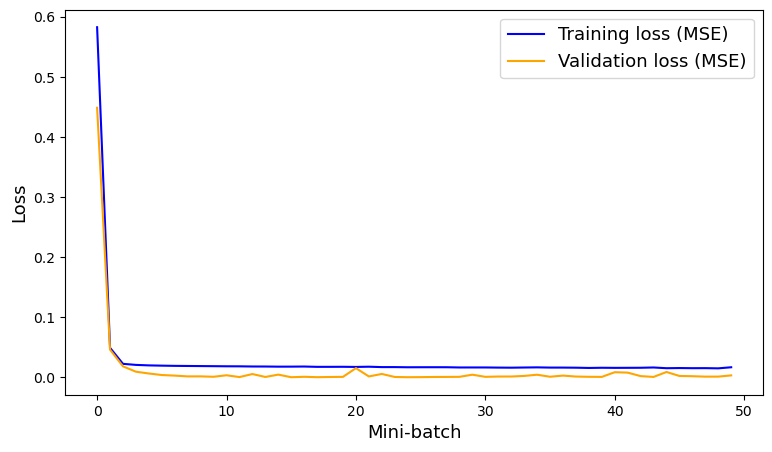

In [47]:
GRU_df =pd.DataFrame(history_3.history)
plt.figure(figsize=(9,5))
plt.plot(GRU_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(GRU_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
# plt.savefig('images/GRU_error1.png', format='png', dpi=1000)
plt.show()

In [50]:
# Define MLP model
MLP_Model = tf.keras.models.Sequential([
    Input(shape=(lookback, n_features)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(5)
    # Reshape((5,1))
])

MLP_Model.compile(optimizer = 'Adam', loss='mse', metrics=["mae"])
MLP_Model.summary()

np.random.seed(123)
history_4 = MLP_Model.fit(xtrain, ytrain,
                          epochs=90,
                          validation_data=(xvalid, yvalid))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 5)                 0         
                                                                 
 dense_8 (Dense)             (None, 64)                384       
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 5)                 165       
                                                                 
Total params: 2,629
Trainable params: 2,629
Non-trainable params: 0
_________________________________________________________________
Epoch 1/90
89/89 [==============================] - 4s 15ms/step - loss: 1.0752 - mae: 0.7073 - val_loss: 0.0584 - val_mae: 0.2152
Epoch 2/90
89/89 [==============================] - 1

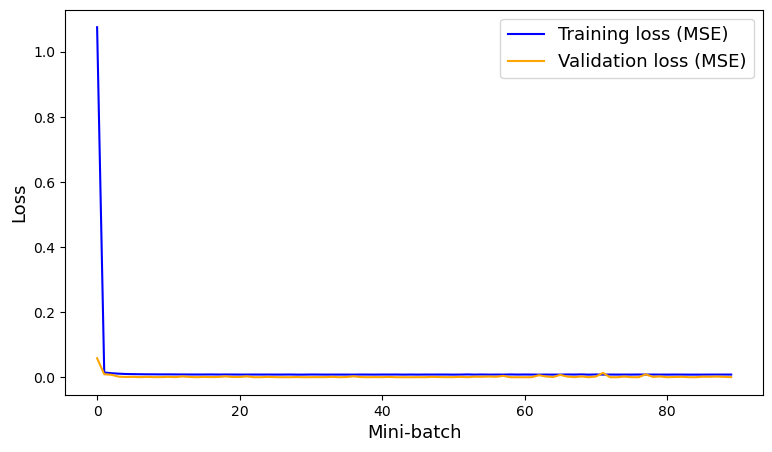

In [51]:
MLP_df =pd.DataFrame(history_4.history)
plt.figure(figsize=(9,5))
plt.plot(MLP_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(MLP_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
# plt.savefig('images/MLP_Model.png', format='png', dpi=1000)
plt.show()

In [52]:
# Define Conv1D model
conv1D_Model = tf.keras.models.Sequential([
    Input(shape=(lookback, n_features)),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(5),
    Reshape((5,1))
])

conv1D_Model.compile(optimizer = 'Adam', loss='mse', metrics=["mae"])
conv1D_Model.summary()

np.random.seed(1)
history_5 = conv1D_Model.fit(xtrain,ytrain,batch_size=300,epochs=50,validation_data=(xvalid,yvalid), verbose = 1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 32)             128       
                                                                 
 flatten_2 (Flatten)         (None, 96)                0         
                                                                 
 dense_11 (Dense)            (None, 5)                 485       
                                                                 
 reshape_2 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 613
Trainable params: 613
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - 4s 84ms/step - loss: 2.7949 - mae: 1.5112 - val_loss: 8.9939 - val_mae: 2.9331
Epoch 2/50
10/10 [==============================] - 0s 23

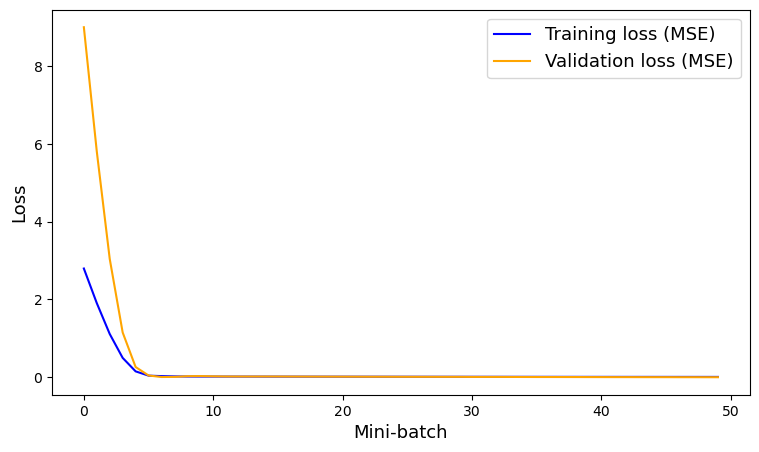

In [53]:
conv1D_df = pd.DataFrame(history_5.history)
print('')
plt.figure(figsize=(9,5))
plt.plot(conv1D_df['loss'], label ='Training loss (MSE)', color = 'blue')
plt.plot(conv1D_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
plt.xlabel('Mini-batch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
# plt.savefig('images/conv1D_Model.png', format='png', dpi=1000)
plt.show()

## Fitting All The Models

## Predictions
Now we will use our model to make predictions.

In [54]:
real_pred1 = RNN.predict(xtest)
real_pred2 = LSTM_Model.predict(xtest)
real_pred3 = GRU_Model.predict(xtest)
real_pred4 = MLP_Model.predict(xtest)
real_pred5 = conv1D_Model.predict(xtest)

30/30 [==============================] - 0s 5ms/step


In [56]:
real_pred1.shape,real_pred2.shape,real_pred3.shape,real_pred4.shape,real_pred5.shape

((949, 5, 1), (949, 5), (949, 5, 1), (949, 5), (949, 5, 1))

In [57]:
# Combined Models
Pred_Data = pd.DataFrame({
    'RNN': real_pred1[:,0].flatten(),
    'LSTM': real_pred2[:,0].flatten(),
    'GRU': real_pred3[:,0].flatten(),
    'MLP': real_pred4[:,0].flatten(),  
    'conv1D': real_pred5[:,0].flatten(),  
    'Actual Rate': xtest[:,0].flatten()
})

Pred_Data.head()


,RNN,LSTM,GRU,MLP,conv1D,Actual Rate
0,4.431067,4.354355,4.520034,4.400984,4.379480,4.4179
1,4.431068,4.354454,4.520886,4.400976,4.379653,4.4187
2,4.431068,4.354510,4.521525,4.400979,4.379699,4.4193
3,4.432282,4.355581,4.521525,4.401849,4.379839,4.4193
4,4.435003,4.357877,4.521525,4.404254,4.380301,4.4193


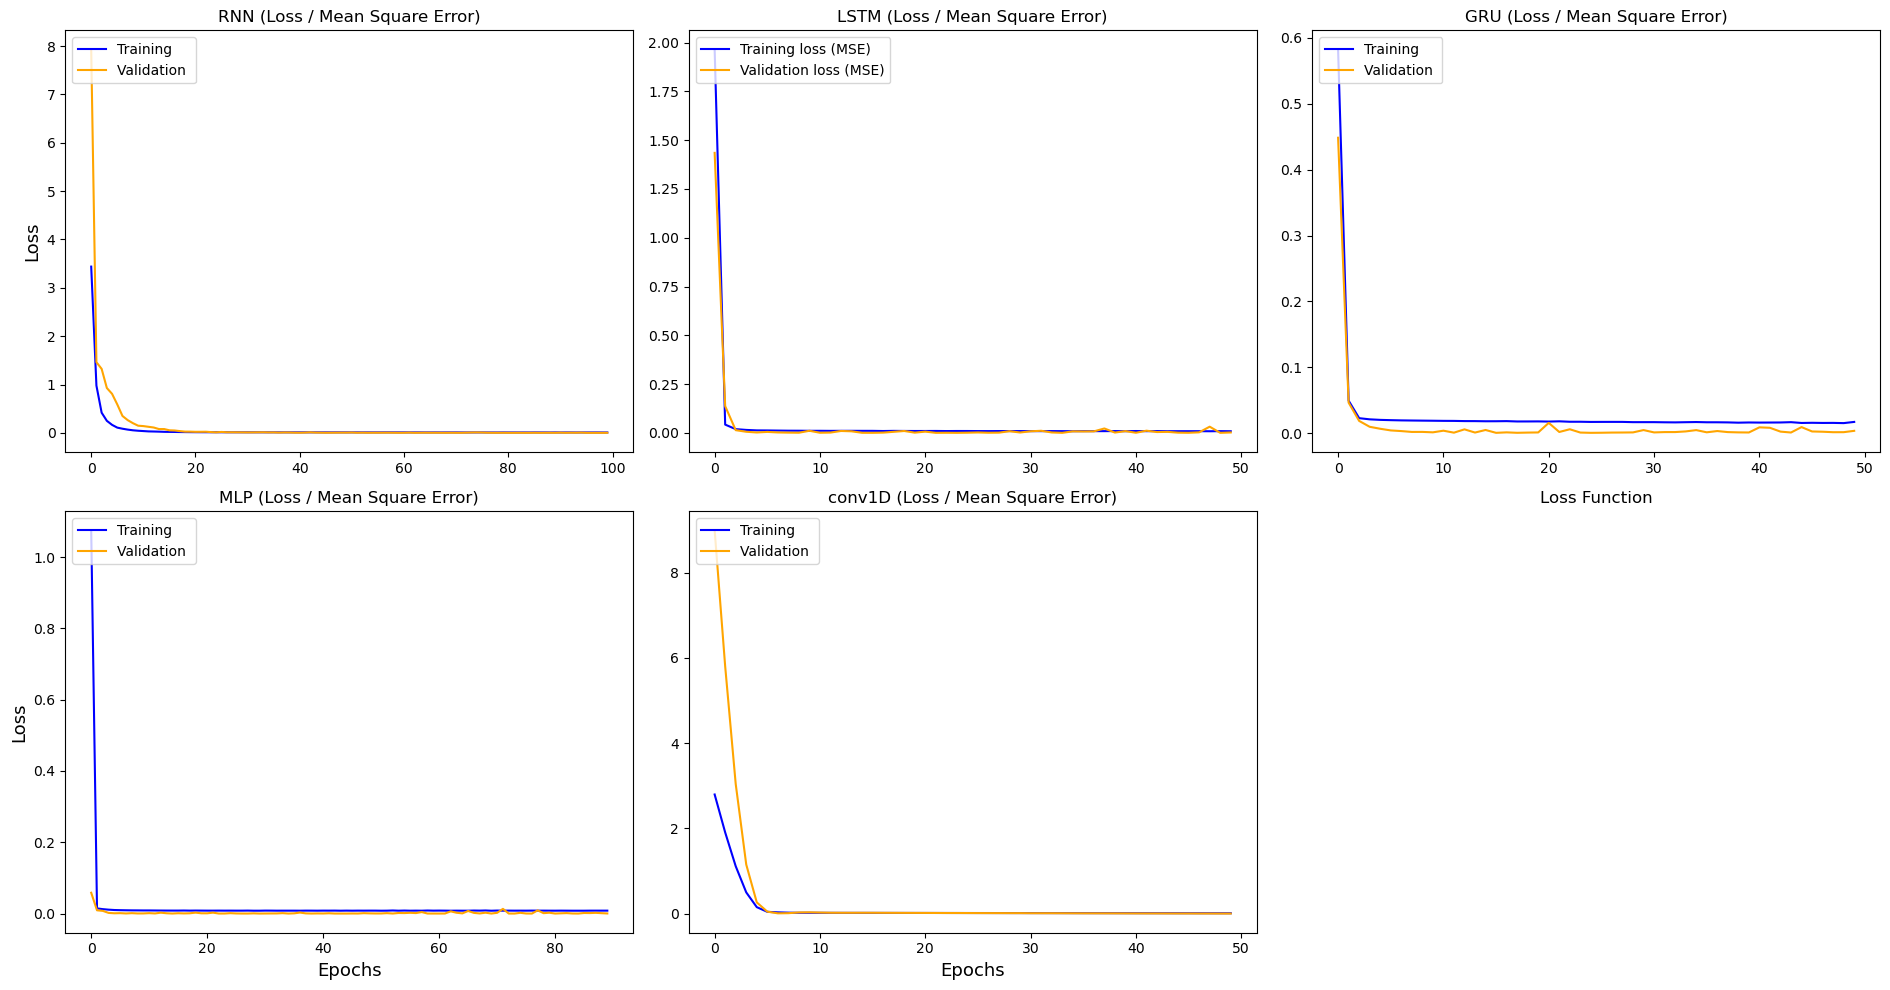

In [60]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(19,10))

axs[0,0].plot(RNN_df['loss'], label ='Training ', color = 'blue')
axs[0,0].plot(RNN_df['val_loss'], label='Validation ', color = 'orange')
axs[0,0].set_title('RNN (Loss / Mean Square Error)')

axs[0,1].plot(LSTM_df['loss'], label ='Training loss (MSE)', color = 'blue')
axs[0,1].plot(LSTM_df['val_loss'], label='Validation loss (MSE)', color = 'orange')
axs[0,1].set_title('LSTM (Loss / Mean Square Error)')

axs[0,2].plot(GRU_df['loss'], label ='Training ', color = 'blue')
axs[0,2].plot(GRU_df['val_loss'], label='Validation ', color = 'orange')
axs[0,2].set_title('GRU (Loss / Mean Square Error)')

axs[1,0].plot(MLP_df['loss'], label ='Training ', color = 'blue')
axs[1,0].plot(MLP_df['val_loss'], label='Validation ', color = 'orange')
axs[1,0].set_title('MLP (Loss / Mean Square Error)')

axs[1,1].plot(conv1D_df['loss'], label ='Training', color = 'blue')
axs[1,1].plot(conv1D_df['val_loss'], label='Validation ', color = 'orange')
axs[1,1].set_title('conv1D (Loss / Mean Square Error)')

axs[1,2].set_title('Loss Function')
# Add a blank subplot to fill the last space in the grid
axs[1,2].axis('off')
#Add legend to all plots
axs[0,0].legend(loc='upper left')
axs[0,1].legend(loc='upper left')
axs[0,2].legend(loc='upper left')
axs[1,0].legend(loc='upper left')
axs[1,1].legend(loc='upper left')
# Add a shared x-axis label to the bottom row of subplots
for ax in axs[1,:]:
    ax.set_xlabel('Epochs', fontsize=13)

# Add a shared y-axis label to the left column of subplots
for ax in axs[:,0]:
    ax.set_ylabel('Loss', fontsize=13)
    


    
plt.tight_layout()
plt.savefig('../images/lossfnx_usd_relu.png', format='png', dpi=1000)
plt.show()


## Combined Plots

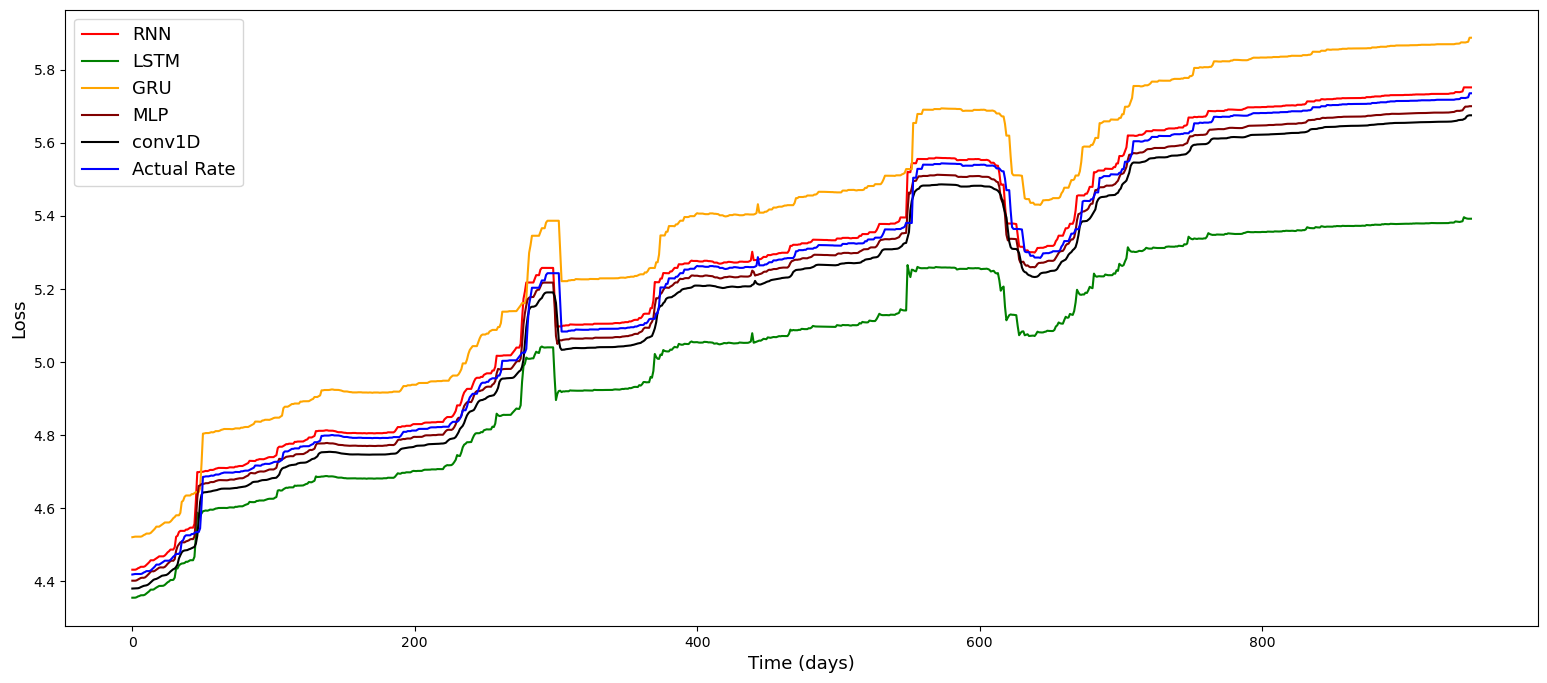

In [62]:

plt.figure(figsize=(19,8))
plt.plot(Pred_Data['RNN'], color = 'red', label = 'RNN')
plt.plot(Pred_Data['LSTM'], color = 'green', label = 'LSTM')
plt.plot(Pred_Data['GRU'], color = 'orange', label = 'GRU')
plt.plot(Pred_Data['MLP'], color = 'maroon', label = 'MLP')
plt.plot(Pred_Data['conv1D'], color = 'black', label = 'conv1D')
plt.plot(xtest[:,0,0].flatten(), color = 'blue', label = 'Actual Rate')
plt.xlabel('Time (days)', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
# plt.savefig('images/Combined1.png', format='png', dpi=1000)
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\Users\Kalong\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Kalong\AppData\Local\Temp\ipykernel_8256\439220632.py", line 50, in <module>
    plt.savefig('images/Combined2.png', format='png', dpi=1000)
  File "c:\Users\Kalong\anaconda3\lib\site-packages\matplotlib\pyplot.py", line 979, in savefig
    res = fig.savefig(*args, **kwargs)
  File "c:\Users\Kalong\anaconda3\lib\site-packages\matplotlib\figure.py", line 3046, in savefig
    self.canvas.print_figure(fname, **kwargs)
  File "c:\Users\Kalong\anaconda3\lib\site-packages\matplotlib\backend_bases.py", line 2319, in print_figure
    result = print_method(
  File "c:\Users\Kalong\anaconda3\lib\site-packages\matplotlib\backend_bases.py", line 1648, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\Kalong\anaconda3\lib\site-packages\matplotlib\_api\deprecation.py", line 41

TypeError: object of type 'NoneType' has no len()

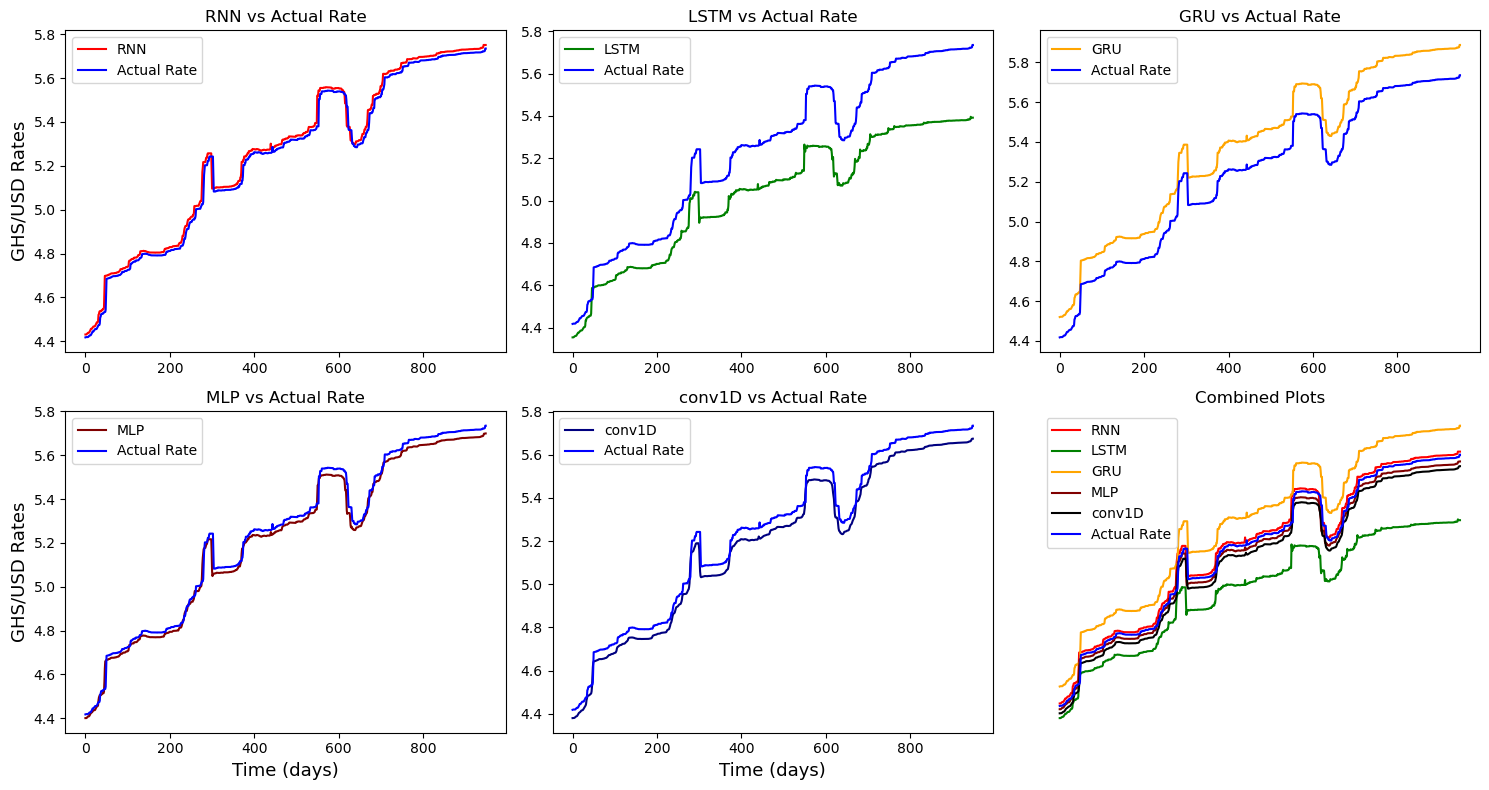

In [63]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

axs[0,0].plot(Pred_Data['RNN'], color='red', label='RNN')
axs[0,0].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Rate')
axs[0,0].set_title('RNN vs Actual Rate')

axs[0,1].plot(Pred_Data['LSTM'], color='green', label='LSTM')
axs[0,1].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Rate')
axs[0,1].set_title('LSTM vs Actual Rate')

axs[0,2].plot(Pred_Data['GRU'], color='orange', label='GRU')
axs[0,2].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Rate')
axs[0,2].set_title('GRU vs Actual Rate')

axs[1,0].plot(Pred_Data['MLP'], color='maroon', label='MLP')
axs[1,0].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Rate')
axs[1,0].set_title('MLP vs Actual Rate')

axs[1,1].plot(Pred_Data['conv1D'], color='navy', label='conv1D')
axs[1,1].plot(xtest[:,0,0].flatten(), color='blue', label='Actual Rate')
axs[1,1].set_title('conv1D vs Actual Rate')

axs[1,2].plot(Pred_Data['RNN'], color = 'red', label = 'RNN')
axs[1,2].plot(Pred_Data['LSTM'], color = 'green', label = 'LSTM')
axs[1,2].plot(Pred_Data['GRU'], color = 'orange', label = 'GRU')
axs[1,2].plot(Pred_Data['MLP'], color = 'maroon', label = 'MLP')
axs[1,2].plot(Pred_Data['conv1D'], color = 'black', label = 'conv1D')
axs[1,2].plot(xtest[:,0,0].flatten(), color = 'blue', label = 'Actual Rate')

axs[1,2].set_title('Combined Plots')
# Add a blank subplot to fill the last space in the grid
axs[1,2].axis('off')

axs[0,0].legend(loc='upper left')
axs[0,1].legend(loc='upper left')
axs[0,2].legend(loc='upper left')
axs[1,0].legend(loc='upper left')
axs[1,1].legend(loc='upper left')
axs[1,2].legend(loc='upper left')
# Add a shared x-axis label to the bottom row of subplots
for ax in axs[1,:]:
    ax.set_xlabel('Time (days)', fontsize=13)

# Add a shared y-axis label to the left column of subplots
for ax in axs[:,0]:
    ax.set_ylabel('GHS/USD Rates', fontsize=13)
    

plt.tight_layout()
plt.savefig('images/Combined2.png', format='png', dpi=1000)
plt.show()


In [81]:
# plt.figure(figsize=(19,8))
# plt.plot(Pred_Data['RNN'], color='red', label='RNN')
# plt.plot(xtest[:,0,0].flatten(), color='blue', label='Actual Rate')
# plt.xlabel('Time (days)', fontsize=13)
# plt.ylabel('Exchange Rate', fontsize=13)
# plt.title('RNN vs Actual Rate', fontsize=13)
# plt.legend(fontsize=13,loc='upper left', ncol=2)
# plt.show()


In [82]:
# Assuming xtest is the test data and has shape (num_samples, num_timesteps, num_features)
rnn_pred = RNN.predict(xtest)
lstm_pred = LSTM_Model.predict(xtest)
gru_pred = GRU_Model.predict(xtest)
mlp_pred = MLP_Model.predict(xtest)
conv1d_pred = conv1D_Model.predict(xtest)


30/30 [==============================] - 0s 3ms/step


In [84]:
# Combined Models
Pred_Data = pd.DataFrame({
    'RNN': rnn_pred[:,0].flatten(),
    'LSTM': lstm_pred[:,0].flatten(),
    'GRU': gru_pred[:,0].flatten(),
    'MLP': mlp_pred[:,0].flatten(),  # fixed typo here
    'conv1D': conv1d_pred[:,0].flatten(),  # fixed typo here
    'Actual Rate': xtest[:,0].flatten()
})

Pred_Data.head()

,RNN,LSTM,GRU,MLP,conv1D,Actual Rate
0,5.948361,5.874539,5.994513,5.904864,5.905824,5.9385
1,5.948372,5.870703,5.951940,5.909400,5.909331,5.8972
2,5.908739,5.859576,5.973697,5.880883,5.900522,5.9183
3,5.901913,5.853568,5.973697,5.861912,5.892575,5.9183
4,5.901998,5.847326,5.973697,5.855451,5.887012,5.9183


In [85]:
actuals = ytest.reshape(-1, 1)
actuals.shape,Pred_Data.shape

((949, 1), (949, 6))

In [86]:
# print('')
# plt.figure(figsize=(10,5))
# plt.plot(actuals, label="Actual Rate", color = 'blue')
# plt.plot(Pred_Data['RNN'], label="RNN", color = 'red')
# plt.xlabel('Time (days)', fontsize=13)
# plt.ylabel('Rate', fontsize=13)
# plt.legend(fontsize=13)
# plt.show()

In [87]:
print('The the mean absolute error committed by the standard RNN model is: ', mean_absolute_error(actuals,Pred_Data['RNN']))

The the mean absolute error committed by the standard RNN model is:  0.03953548379542329


In [88]:
# Evaluate RNN predictions
rnn_mae = mean_absolute_error(ytest, Pred_Data['RNN'])
rnn_mse = mean_squared_error(ytest, Pred_Data['RNN'])
rnn_rmse = np.sqrt(rnn_mse)
rnn_r2 = r2_score(ytest, Pred_Data['RNN'])

# Evaluate LSTM predictions
lstm_mae = mean_absolute_error(ytest, Pred_Data['LSTM'])
lstm_mse = mean_squared_error(ytest, Pred_Data['LSTM'])
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(ytest, Pred_Data['LSTM'])

# Evaluate GRU predictions
gru_mae = mean_absolute_error(ytest, Pred_Data['GRU'])
gru_mse = mean_squared_error(ytest, Pred_Data['GRU'])
gru_rmse = np.sqrt(gru_mse)
gru_r2 = r2_score(ytest, Pred_Data['GRU'])

# Evaluate MLP predictions
mlp_mae = mean_absolute_error(ytest, Pred_Data['MLP'])
mlp_mse = mean_squared_error(ytest, Pred_Data['MLP'])
mlp_rmse = np.sqrt(mlp_mse)
mlp_r2 = r2_score(ytest, Pred_Data['MLP'])

# Evaluate Conv1D predictions
conv1d_mae = mean_absolute_error(ytest, Pred_Data['conv1D'])
conv1d_mse = mean_squared_error(ytest, Pred_Data['conv1D'])
conv1d_rmse = np.sqrt(conv1d_mse)
conv1d_r2 = r2_score(ytest, Pred_Data['conv1D'])


In [89]:
print("RNN Evaluation Metrics:")
print(f"MAE: {rnn_mae:.4f}, MSE: {rnn_mse:.4f}, RMSE: {rnn_rmse:.4f}, R2: {rnn_r2:.4f}\n")

print("LSTM Evaluation Metrics:")
print(f"MAE: {lstm_mae:.4f}, MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, R2: {lstm_r2:.4f}\n")

print("GRU Evaluation Metrics:")
print(f"MAE: {gru_mae:.4f}, MSE: {gru_mse:.4f}, RMSE: {gru_rmse:.4f}, R2: {gru_r2:.4f}\n")

print("MLP Evaluation Metrics:")
print(f"MAE: {mlp_mae:.4f}, MSE: {mlp_mse:.4f}, RMSE: {mlp_rmse:.4f}, R2: {mlp_r2:.4f}\n")

print("Conv1D Evaluation Metrics:")
print(f"MAE: {conv1d_mae:.4f}, MSE: {conv1d_mse:.4f}, RMSE: {conv1d_rmse:.4f}, R2: {conv1d_r2:.4f}\n")


RNN Evaluation Metrics:
MAE: 0.0395, MSE: 0.0023, RMSE: 0.0479, R2: 0.9904

LSTM Evaluation Metrics:
MAE: 0.0806, MSE: 0.0086, RMSE: 0.0930, R2: 0.9638

GRU Evaluation Metrics:
MAE: 0.0787, MSE: 0.0105, RMSE: 0.1022, R2: 0.9562

MLP Evaluation Metrics:
MAE: 0.0294, MSE: 0.0017, RMSE: 0.0415, R2: 0.9928

Conv1D Evaluation Metrics:
MAE: 0.0422, MSE: 0.0035, RMSE: 0.0588, R2: 0.9855



In [90]:
# Create a DataFrame with evaluation metrics
Results = pd.DataFrame({'MAE': [rnn_mae, lstm_mae, gru_mae, mlp_mae, conv1d_mae],
                        'MSE': [rnn_mse, lstm_mse, gru_mse, mlp_mse, conv1d_mse],
                        'RMSE': [rnn_rmse, lstm_rmse, gru_rmse, mlp_rmse, conv1d_rmse],
                        'R2': [rnn_r2, lstm_r2, gru_r2, mlp_r2, conv1d_r2]},
                       index=['RNN', 'LSTM', 'GRU', 'MLP', 'Conv1D'])
Results

,MAE,MSE,RMSE,R2
RNN,0.039535,0.002296,0.047919,0.990384
LSTM,0.080556,0.008647,0.092991,0.963789
GRU,0.078681,0.010455,0.102249,0.956220
MLP,0.029373,0.001719,0.041463,0.992801
Conv1D,0.042233,0.003455,0.058780,0.985532
